### A股市场月度收益的PCA分析
从TuShare接口获取A股市场的月度收益数据，然后进行PCA分析，获得标准化的各个成分的收益时序，最后画图查看它们的累计收益曲线。

In [4]:
# 从TuShare接口获取所需要的数据
import tushare as ts
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

ts.set_token('')

pro = ts.pro_api()

def get_month_last_data(start_date, end_date):
    trdate = pro.trade_cal(start_date=start_date, end_date=end_date)
    trdate['year'] = trdate['cal_date'].apply(lambda x: int(x[0:4]))  # 添加一个year、month列
    trdate['month'] = trdate['cal_date'].apply(lambda x: int(x[4:6]))
    tr_mon_last_date = trdate[ trdate['is_open'] == 1 ].groupby(['year', 'month']).last()
    tr_mon_last_date = list(tr_mon_last_date.cal_date)
    mon_last_date = trdate.groupby(['year', 'month']).last()
    mon_last_date = list(mon_last_date.cal_date)
    
    return tr_mon_last_date, mon_last_date

def get_mon_ret_data(datelist):
    ret_monthly_raw = pd.DataFrame()
    for tr_date in datelist:
        df = pro.monthly(trade_date=tr_date, fields='ts_code, trade_date, pct_chg')
        ret_monthly_raw = ret_monthly_raw.append(df)
    # 获取个股下一个月的收益
    ret_monthly = ret_monthly_raw.copy()
    ret_monthly['rR_mon'] = ret_monthly['pct_chg'] / 100
    ret_monthly = ret_monthly.sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
    # 最后清理一下表
    ret_monthly = ret_monthly[['trade_date', 'ts_code', 'rR_mon']]

    return ret_monthly

tr_mon_last_date, mon_last_date = get_month_last_data(start_date='20021201', end_date='20181231')
ret_monthly = get_mon_ret_data(mon_last_date)
ret_monthly_stk = ret_monthly.pivot(index='trade_date', columns='ts_code', values='rR_mon')  # pivot()函数

In [10]:
# PCA分析
from sklearn.decomposition import PCA

# 只看那些非nan值占比超过90%的股票，然后让这些股票的nan值填充为0
value_keep = (ret_monthly_stk.count() / len(ret_monthly_stk)) > 0.9
value_keep = list(value_keep[value_keep == True].index)
ret_monthly_stk_input = ret_monthly_stk[ value_keep ].fillna(0)  # fillna()函数

# 主成分分解
n_components = 20
pca = PCA(n_components=n_components)
pca.fit(ret_monthly_stk_input)
### 各个主成分的解释力度
print('各个主成分的解释力度：')
print(pca.explained_variance_ratio_ )
### 各个主成分的构成权重(让第一主成分的权重和标准化为1)
weight = pca.components_
print('权重矩阵的行之和：')
print(weight.sum(axis=1))
weight = weight / weight.sum(axis=1)[0]  # 权重和的归一化
print('让第一主成分的权重和为1(所有权重系数都除以第一主成分权重和)的权重矩阵的行之和：')
print(weight.sum(axis=1))
### 计算各个主成分的收益时序
ret_monthly_stk_output = np.dot(ret_monthly_stk_input, weight.T)
ret_monthly_stk_output = pd.DataFrame(ret_monthly_stk_output, columns=range(n_components))

各个主成分的解释力度：
[0.4132487  0.02732874 0.02227265 0.01883109 0.01565964 0.01513981
 0.01330589 0.01204072 0.0104113  0.009064   0.00902606 0.0085772
 0.00843101 0.00819455 0.00814514 0.00742884 0.00733117 0.00689699
 0.0066289  0.00631128]
权重矩阵的行之和：
[32.80276974 -2.15872186  0.14955437 -1.7863051  -0.48431895 -0.367615
 -1.12414669  0.945492   -0.46525534  0.73684806  1.20518202  1.15029921
  0.22735304 -0.2874342  -0.50614668  0.32623896  0.08000054 -0.73549138
  0.17359838 -0.05089083]
让第一主成分的权重和为1(所有权重系数都除以第一主成分权重和)的权重矩阵的行之和：
[ 1.         -0.06580913  0.0045592  -0.05445592 -0.01476457 -0.01120683
 -0.03426987  0.02882354 -0.01418342  0.02246298  0.03674025  0.03506714
  0.00693091 -0.0087625  -0.01543     0.00994547  0.00243883 -0.02242162
  0.00529219 -0.00155142]


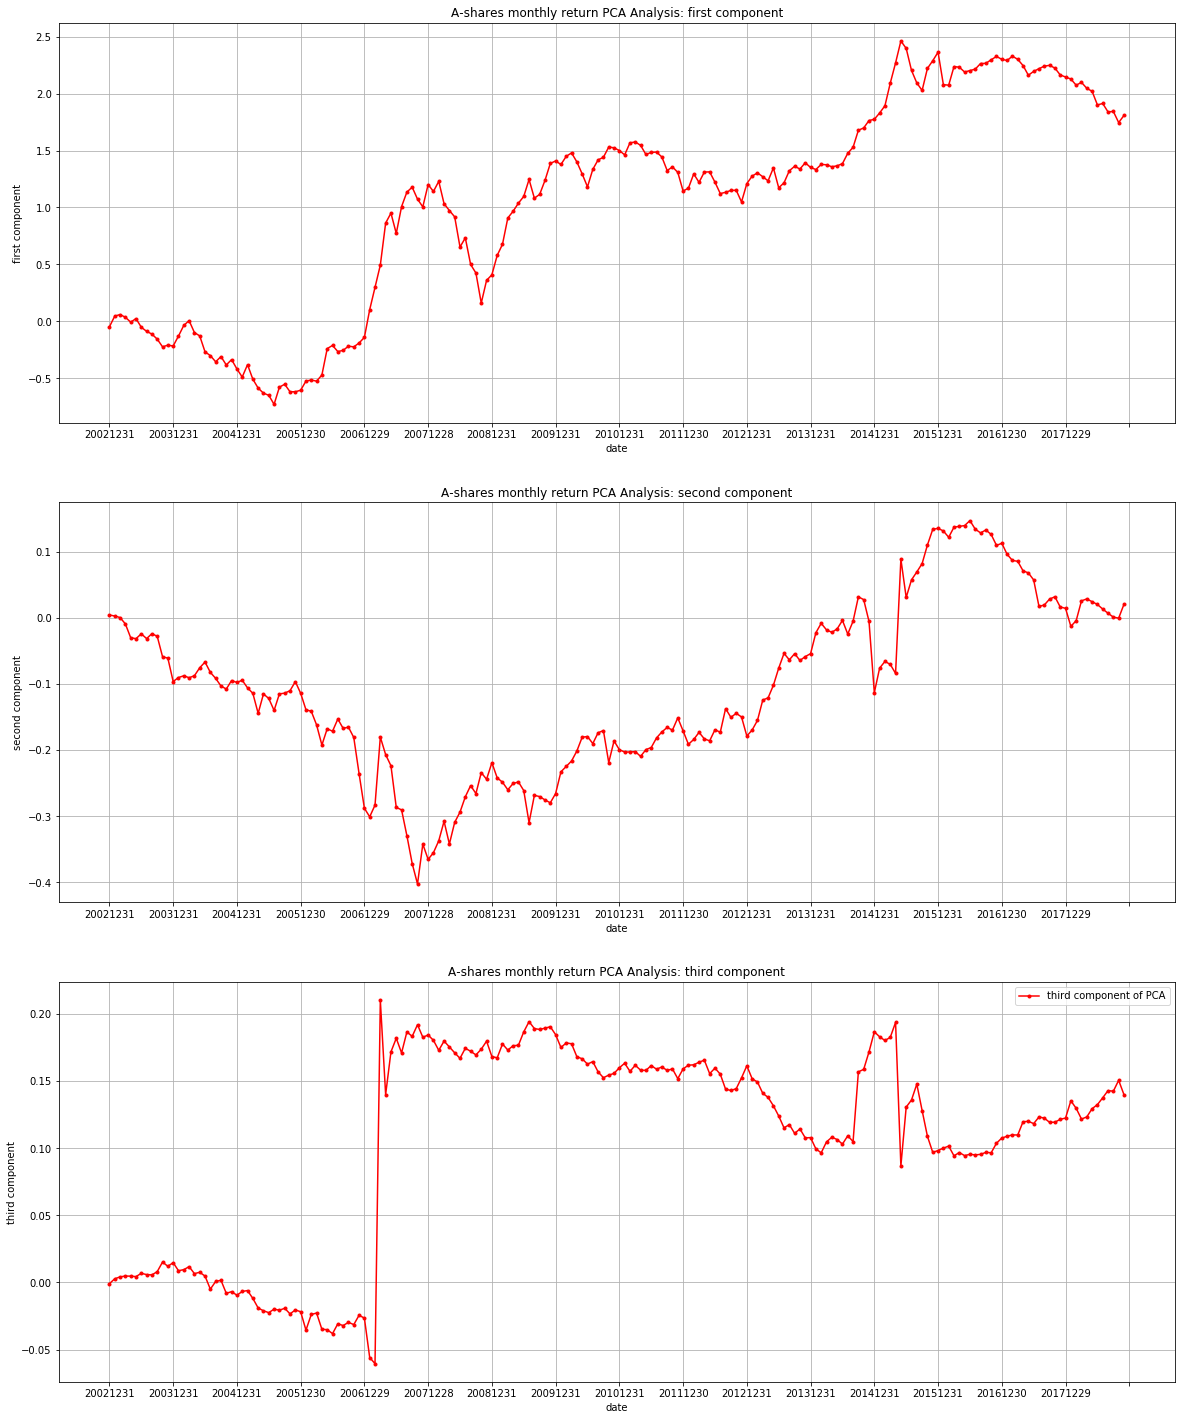

In [9]:
# 主成分分解出来的各个成分的时序画图，查看它们的累计收益
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline

xmajorLocator = MultipleLocator(12)  # 让x轴不那么密集

x_date = tr_mon_last_date[0:-1]
fig = plt.figure(figsize=(20, 25))

# subplot画图
ax = plt.subplot(3, 1, 1)
plt.grid()
plt.title('A-shares monthly return PCA Analysis: first component')
plt.xlabel('date')
plt.ylabel("first component")
ax.xaxis.set_major_locator(xmajorLocator)
plt.plot(x_date, ret_monthly_stk_output[0].cumsum(), '.r-', label="first component of PCA")

ax = plt.subplot(3, 1, 2)
plt.grid()
plt.title('A-shares monthly return PCA Analysis: second component')
plt.xlabel('date')
plt.ylabel("second component")
ax.xaxis.set_major_locator(xmajorLocator)
plt.plot(x_date, ret_monthly_stk_output[1].cumsum(), '.r-', label="second component of PCA")

ax = plt.subplot(3, 1, 3)
plt.grid()
plt.title('A-shares monthly return PCA Analysis: third component')
plt.xlabel('date')
plt.ylabel("third component")
ax.xaxis.set_major_locator(xmajorLocator)
plt.plot(x_date, ret_monthly_stk_output[2].cumsum(), '.r-', label="third component of PCA")
plt.legend()